In [1]:
import os
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, GRU, Embedding, Bidirectional, RepeatVector, \
    Concatenate, Activation, Dot, Lambda
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow.keras.backend as K

import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

In [2]:
# do softmax over the time axis
# expected shape of the output N x T x D

def softmax_over_time(x):
    assert K.ndim(x) > 2
    e = K.exp(x - K.max(x, axis=1, keepdims=True))
    s = K.sum(e, axis=1, keepdims=True)
    return e / s

In [3]:
# configurations
BATCH_SIZE = 64
EPOCHS = 100
LATENT_DIM = 256
LATENT_DIM_DECODER = 256
NUM_SAMPLES = 10000
MAX_SEQUENCE_LENGTH = 100
MAX_NUM_WORDS = 20000
EMBEDDING_DIM = 300

In [4]:
# where we will store the data
input_texts = [] # sentence in original language
target_texts = [] # sentence in target language
target_texts_inputs = [] # sentence in target language offset by 1, target sentence but addition of <sos> token

In [5]:
# load in the data
t = 0
for line in open('data/translation_data.txt'):
    # only keep limited number of samples
    # the samples in our data are somewhat ordered by length
    # we want to keep mostly the short sequences because when doing padding you do not want a lot of zeros
    t += 1
    if t > NUM_SAMPLES:
        break

    # input and target are seperated by tab
    if '\t' not in line:
        continue

    # split up the input and translation
    input_text, translation = line.split('\t')[:2]

    # we are using teacher forcing
    target_text = translation + ' <eos>'
    target_text_input = '<sos> ' + translation

    input_texts.append(input_text)
    target_texts.append(target_text)
    target_texts_inputs.append(target_text_input)

print("Number of samples:", len(input_texts))

Number of samples: 10000


In [6]:
input_texts, target_texts, target_texts_inputs = shuffle(input_texts, target_texts, target_texts_inputs)

In [7]:
# tokenize the inputs
tokenizer_inputs = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer_inputs.fit_on_texts(input_texts)
input_sequences = tokenizer_inputs.texts_to_sequences(input_texts)

In [8]:
# word index mapping for input language
word2idx_inputs = tokenizer_inputs.word_index
print(f"Found {len(word2idx_inputs)} unique tokens in input corpus")

Found 3047 unique tokens in input corpus


In [9]:
# determine max sequence length for input
max_len_input = max(len(s) for s in input_sequences)
max_len_input

6

In [10]:
# tokenizing the outputs
tokenizer_outputs = Tokenizer(num_words=MAX_NUM_WORDS, filters='')
tokenizer_outputs.fit_on_texts(target_texts + target_texts_inputs)
target_sequences = tokenizer_outputs.texts_to_sequences(target_texts)
target_sequences_inputs = tokenizer_outputs.texts_to_sequences(target_texts_inputs)

In [11]:
# word index mapping for target language
word2idx_outputs = tokenizer_outputs.word_index
print(f"Found {len(word2idx_outputs)} unique tokens in output corpus")

Found 8089 unique tokens in output corpus


In [12]:
# storing the number of outputs for later
# remember indexing starts at 1 so add 1
num_words_output = len(word2idx_outputs) + 1

In [13]:
# determine max sequence length for output
max_len_output = max(len(s) for s in target_sequences)
max_len_output

9

In [14]:
# padding the sequences
encoder_inputs = pad_sequences(input_sequences, maxlen=max_len_input)
print("Encoder data shape:", encoder_inputs.shape)
print("Encoder data[0]:", encoder_inputs[0])

decoder_inputs = pad_sequences(target_sequences_inputs, maxlen=max_len_output, padding='post')
print("Decoder data shape:", decoder_inputs.shape)
print("Decoder data[0]:", decoder_inputs[0])

decoder_targets = pad_sequences(target_sequences, maxlen=max_len_output, padding='post')

Encoder data shape: (10000, 6)
Encoder data[0]: [  0   0   1 543 185  17]
Decoder data shape: (10000, 9)
Decoder data[0]: [   2    7  786 2828    0    0    0    0    0]


In [15]:
# load in pretrained word vectors
print("Loading word vectors...")
word2vec = {}
with open(os.path.join('data/glove.6B.%sd.txt' % EMBEDDING_DIM)) as f:
    # format of the file is space seperated values
    for line in f:
        values = line.split()
        word = values[0]
        vec = np.asarray(values[1:], dtype='float32')
        word2vec[word] = vec

print(f"Found {len(word2vec)} word vectors")

Loading word vectors...
Found 400001 word vectors


In [16]:
# prepare embedding matrix
print("Filling pre-trained embeddings...")
num_words = min(MAX_NUM_WORDS, len(word2idx_inputs) + 1) # remember embeddings start at 1
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word2idx_inputs.items():
    if i < MAX_NUM_WORDS:
        embedding_vector = word2vec.get(word)
        if embedding_vector is not None:
            # words not found in embedding matrix will be all zeros
            embedding_matrix[i] = embedding_vector

Filling pre-trained embeddings...


In [17]:
# load in pretrained word vectors
print("Loading word vectors...")
word2vec_target = {}
with open('data/tr_embeddings.txt') as f:
    # format of the file is space seperated values
    for line in f:
        values = line.split()
        word = values[0]
        vec = np.asarray(values[1:], dtype='float32')
        word2vec_target[word] = vec

print(f"Found {len(word2vec_target)} word vectors")

Loading word vectors...
Found 253832 word vectors


In [18]:
# prepare embedding matrix
print("Filling pre-trained embeddings...")
num_words_target = min(MAX_NUM_WORDS, len(word2idx_outputs) + 1) # remember embeddings start at 1
embedding_matrix_target = np.zeros((num_words_target, EMBEDDING_DIM))
for word, i in word2idx_outputs.items():
    if i < MAX_NUM_WORDS:
        embedding_vector = word2vec_target.get(word)
        if embedding_vector is not None:
            # words not found in embedding matrix will be all zeros
            embedding_matrix_target[i] = embedding_vector

Filling pre-trained embeddings...


In [19]:
# loading pre-trained embeddings to the embedding layer
# setting trainable to false in order to keep embeddings constant
embedding_layer = Embedding(
    num_words,
    EMBEDDING_DIM,
    weights=[embedding_matrix],
    input_length=max_len_input,
)

In [20]:
# loading pre-trained embeddings to the embedding layer
# setting trainable to false in order to keep embeddings constant
embedding_layer_target = Embedding(
    num_words_target,
    EMBEDDING_DIM,
    weights=[embedding_matrix_target],
    input_length=max_len_output,
)

In [21]:
# one-hot targets by which sequence, which word
decoder_one_hot_targets = np.zeros((len(input_texts), max_len_output, num_words_output))
for i, target_sequence in enumerate(decoder_targets):
    for t, word in enumerate(target_sequence):
        decoder_one_hot_targets[i, t, word] = 1

In [22]:
# building the model
# setting up the encoder
encoder_inputs_placeholder = Input(shape=(max_len_input,))
x = embedding_layer(encoder_inputs_placeholder)
encoder = Bidirectional(LSTM(LATENT_DIM, return_sequences=True, dropout=0.5))
encoder_outputs = encoder(x)

# setting up the decoder
decoder_inputs_placeholder = Input(shape=(max_len_output,))
decoder_inputs_x = embedding_layer_target(decoder_inputs_placeholder)

##### Attention #####
# attention layers are global so that we will be able to reuse them in the same function
attn_repeat_layer = RepeatVector(max_len_input)
atnn_concat_layer = Concatenate(axis=-1)
atnn_dense1 = Dense(10, activation='tanh')
atnn_dense2 = Dense(1, activation=softmax_over_time)
atnn_dot = Dot(axes=1)

def one_step_attention(h, st_1):
    # h = h(1), ...., h(Tx), shape = (Tx, LATENT_DIM * 2)
    # st_1 = s(t-1), shape = (LATENT_DIM_DECODER,)

    # copy s(t-1) Tx times
    # Now of shape (Tx, LATENT_DIM_DECODER)
    st_1 = attn_repeat_layer(st_1)

    # concatenate all h(t)s with s(t-1)
    # Now of shape (Tx, LATENT_DIM_DECODER + LATENT_DIM * 2)
    x = atnn_concat_layer([h, st_1])

    # neural net first layer
    x = atnn_dense1(x)

    # second neural net layer with custom softmax
    alphas = atnn_dense2(x)

    # Dot the alphas and the hs
    # a.dot(b) =  sum over a[t] * b[t]
    context = atnn_dot([alphas, h])

    return context

# defining the rest of the decoder (after attention)
decoder_lstm = LSTM(LATENT_DIM_DECODER, return_state=True)
decoder_dense = Dense(num_words_target, activation='softmax')

initial_s = Input(shape=(LATENT_DIM_DECODER,), name='s0')
initial_c = Input(shape=(LATENT_DIM_DECODER,), name='c0')
context_last_word_concat_layer = Concatenate(axis=2) # concat layer for teacher forcing which will combine the previous correct word with the context

# Unlike the previous seq2seq we cannot get the output all in one step
# Instead we need to do Ty steps
# And each step we need to consider all Tx hs

# s, c will be re-assigned in each iteration of the loop
s = initial_s
c = initial_c

# collect outputs in a list at first
outputs = []
for t in range(max_len_output): # Ty times
    # get the context using attention
    context = one_step_attention(encoder_outputs, s)

    # we need a different layer for each time step
    selector = Lambda(lambda x: x[:, t:t+1])
    xt = selector(decoder_inputs_x)

    # combine
    decoder_lstm_input = context_last_word_concat_layer([context, xt])

    # pass the combined [context, last word] into the LSTM
    # along with [s, c]
    # get the new [s, c] and output
    o, s, c = decoder_lstm(decoder_lstm_input, initial_state=[s,c])

    # final dense layer to get next word prediction
    decoder_outputs = decoder_dense(o)
    outputs.append(decoder_outputs)

2022-12-12 22:39:17.601073: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [23]:
# outputs is now a list of length Ty
# each element is of shape (batch_size, output_vocab_size)
# therefore if we simply stack all the outputs into 1 tensor
# it would be of shape T x N x D
# we would like it to be a shape of N x T x D
def stack_and_transpose(x):
    # x is a list of length T, each element is a batch_size x output_vocab_size_tensor
    x = K.stack(x)
    x = K.permute_dimensions(x, pattern=(1,0,2))
    return x

In [24]:
# make it a layer
stacker = Lambda(stack_and_transpose)
outputs = stacker(outputs)

In [25]:
# creating the model
model = Model(
    inputs = [
        encoder_inputs_placeholder,
        decoder_inputs_placeholder,
        initial_s,
        initial_c
    ],
    outputs=outputs
)

In [26]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [27]:
# training the model
z = np.zeros((NUM_SAMPLES, LATENT_DIM_DECODER)) # initial [s,c]
r = model.fit(
    [encoder_inputs, decoder_inputs, z, z], decoder_one_hot_targets,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=0.2
)

Epoch 1/100
125/125 [==============================] - 143s 905ms/step - loss: 2.9711 - accuracy: 0.6158 - val_loss: 2.6747 - val_accuracy: 0.6326
Epoch 2/100
125/125 [==============================] - 82s 653ms/step - loss: 2.4639 - accuracy: 0.6592 - val_loss: 2.5893 - val_accuracy: 0.6415
Epoch 3/100
125/125 [==============================] - 86s 688ms/step - loss: 2.3426 - accuracy: 0.6702 - val_loss: 2.4659 - val_accuracy: 0.6686
Epoch 4/100
125/125 [==============================] - 81s 650ms/step - loss: 2.2499 - accuracy: 0.6767 - val_loss: 2.3962 - val_accuracy: 0.6793
Epoch 5/100
125/125 [==============================] - 90s 719ms/step - loss: 2.1601 - accuracy: 0.6860 - val_loss: 2.3439 - val_accuracy: 0.6890
Epoch 6/100
125/125 [==============================] - 99s 795ms/step - loss: 2.0763 - accuracy: 0.6940 - val_loss: 2.2874 - val_accuracy: 0.6937
Epoch 7/100
125/125 [==============================] - 87s 694ms/step - loss: 2.0030 - accuracy: 0.7012 - val_loss: 2.2360 

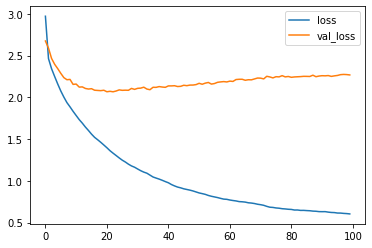

In [28]:
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

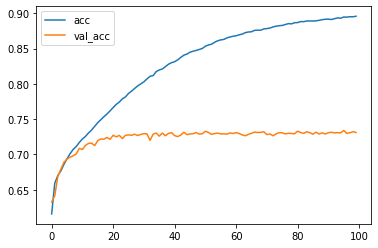

In [29]:
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

In [30]:
##### Making predictions #####
# As with the poetry example, we need to create another model
# that can take in the RNN state and previous word as input
# and accept a T=1 sequence

# The encoder will be stand-alone
# From this we will get our initial decoder hidden state
encoder_model = Model(encoder_inputs_placeholder, encoder_outputs)

# next we define a T=1 decoder model
encoder_outputs_as_input = Input(shape=(max_len_input, LATENT_DIM * 2,))
decoder_inputs_single = Input(shape=(1,))
decoder_inputs_single_x = embedding_layer_target(decoder_inputs_single)

# no need to loop over attention steps this time because there is only one step
context = one_step_attention(encoder_outputs_as_input, initial_s)

# combine context with the last word
decoder_lstm_input = context_last_word_concat_layer([context, decoder_inputs_single_x])

# lstm and final dense
o, s, c = decoder_lstm(decoder_lstm_input, initial_state=[initial_s, initial_c])
decoder_outputs = decoder_dense(o)

# note: we do not really need the final stack and transpose
# because there is only 1 output
# it is already of size N x D
# no need to make it 1 x N x D --> N x 1 x D

In [31]:
# creating the model object
decoder_model = Model(
    inputs=[
        decoder_inputs_single,
        encoder_outputs_as_input,
        initial_s,
        initial_c
    ],
    outputs=[decoder_outputs,s,c]
)

In [32]:
# map indeces back into real words
# so we can view the results
idx2word_eng = {v:k for k, v in word2idx_inputs.items()}
idx2word_trans = {v:k for k, v in word2idx_outputs.items()}

In [33]:
def decode_sequence(input_seq):
    # encode the input as state vectors
    enc_out = encoder_model.predict(input_seq)

    # generate empty target sequence of length 1
    target_seq = np.zeros((1,1))

    # populate the first character of target sequence with the start character
    # note: tokenizer lower case all words
    target_seq[0, 0] = word2idx_outputs['<sos>']

    # break when sentence ends
    eos = word2idx_outputs['<eos>']

    # [s, c] will be updated in each loop iteration
    s = np.zeros((1, LATENT_DIM_DECODER))
    c = np.zeros((1, LATENT_DIM_DECODER))

    # create the translation
    output_sentence = []
    for _ in range(max_len_output):
        o, s, c = decoder_model.predict([target_seq, enc_out, s, c])

        # get the next word
        idx = np.argmax(o.flatten())

        # end sentence with eos
        if eos == idx:
            break

        word = ''
        if idx > 0:
            word = idx2word_trans[idx]
            output_sentence.append(word)

        # update the decoder input
        # which is the word generated just now
        target_seq[0, 0] = idx

    return ' '.join(output_sentence)

In [34]:
while True:
    i = np.random.choice(len(input_texts))
    input_seq = encoder_inputs[i:i+1]
    translation = decode_sequence(input_seq)
    print('-------------------------------')
    print('Input sentence:', input_texts[i])
    print('Predicted translation:', translation)
    print('Actual translation:', target_texts[i])

    ans = input('Continue? [Y/n]')
    if ans and ans.lower().startswith('n'):
        break

1/1 [==============================] - 0s 58ms/step
-------------------------------
Input sentence: I called Tom in.
Predicted translation: tom'u içeri çağırdım.
Actual translation: Tom'u içeri çağırdım. <eos>
